In [1]:
import sys, os, time, copy, gc
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path
import torchvision

import numpy as np
import pandas as pd

import warnings

sys.path.append('../src')
from train import *
from models import *
from dataset import *
from pre_processing import *

/home/sushruth/.local/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-10-25 15:02:12.551759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 15:02:12.566943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 15:02:12.571608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 15:02:12.583367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instru

## Load a specific model

In [2]:
checkpoint_path = Path('../models')

In [3]:
checkpoint_file = "UNet_2024-10-23_17_28.pth"

In [4]:
checkpoint = torch.load(os.path.join(checkpoint_path,checkpoint_file))

/tmp/ipykernel_517573/714819904.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_path,checkpoint_file))


In [5]:
CONFIG = checkpoint['CONFIG']
train_loss = checkpoint['train_loss'] 
valid_loss = checkpoint['valid_loss']
lr_rate = checkpoint['lr_rate']

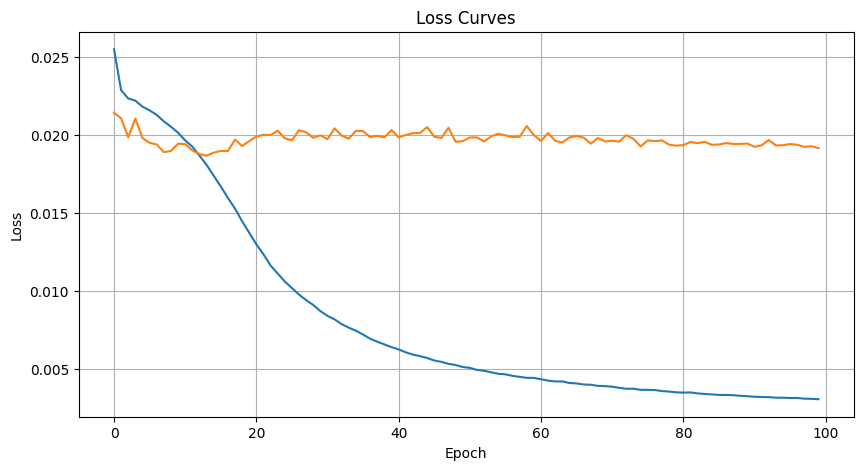

In [6]:
plot_loss_curve(train_loss, valid_loss)

## Set up model for Inference

In [7]:
#override device to cpu for inference
CONFIG['device'] = 'cpu'


In [8]:
model_infer = setup_model(CONFIG)
model_infer.load_state_dict(checkpoint['state_dict'])
#display_trainable_params(model_infer)

<All keys matched successfully>

## Import a dataset

In [9]:
data_path = Path('../datasets')

In [10]:
cifar_train_dataset = torchvision.datasets.CIFAR10(data_path, train=True, transform=None)
cifar_val_dataset = torchvision.datasets.CIFAR10(data_path, train=False, transform=None)

In [11]:
transform_in = getTransform_in(CONFIG)
transform_out = getTransform_out(CONFIG)

In [12]:
train_dataset = BuildImageDataset(cifar_train_dataset, transform_in=transform_in, transform_out=transform_out)
valid_dataset = BuildImageDataset(cifar_val_dataset, transform_in=transform_in, transform_out=transform_out)

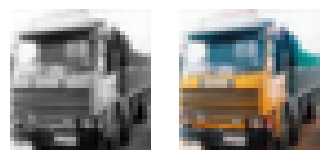

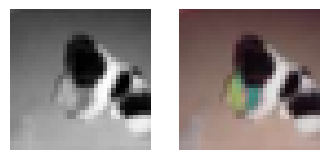

In [16]:
idx_train = np.random.randint(0, len(train_dataset))
idx_valid = np.random.randint(0, len(valid_dataset))
#Display random image from train dataset
train_dataset.display_img_pair(idx = idx_train,upscaling_factor=4)
#Display random image from train dataset
valid_dataset.display_img_pair(idx = idx_valid,upscaling_factor=4)

# Run Inference

In [17]:
input_train_img = train_dataset.__getitem__(idx_train)[0]
input_valid_img = valid_dataset.__getitem__(idx_valid)[0]
with torch.no_grad():
    out_train_img = model_infer(input_train_img.unsqueeze(0))
    out_valid_img = model_infer(input_valid_img.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


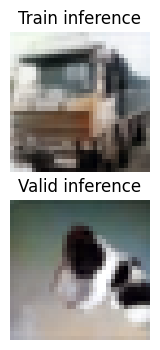

In [18]:
inf_train_img = np.transpose(out_train_img.squeeze(0).detach(),(1,2,0))
inf_val_img = np.transpose(out_valid_img.squeeze(0).detach(),(1,2,0))
#denormalize from transforms_basic
inf_train_img = inf_train_img/2 + 0.5
inf_val_img = inf_val_img/2 + 0.5
plt.figure(figsize=(4,4))
plt.subplot(2, 1, 1)
plt.imshow(inf_train_img, interpolation='nearest')
plt.title('Train inference')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(inf_val_img, interpolation='nearest')
plt.title('Valid inference')
plt.axis('off')
plt.show()

In [19]:
#List of clipped pixels in the image
clipped_pixels_train = np.transpose(np.where(inf_train_img > 1),(1,0))
clipped_pixels_val = np.transpose(np.where(inf_val_img > 1),(1,0))


In [20]:
print(len(clipped_pixels_val), len(clipped_pixels_train))

37 0


## Inferring on a larger image with a network trained on just CIFAR

In [311]:
import random
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import importlib
# random images from COCO
image_urls = [
    "https://farm1.staticflickr.com/97/246719425_9d4359b4f5_z.jpg",
    "https://farm6.staticflickr.com/5531/9080730449_47f592f094_z.jpg"

]
random_url = random.choice(image_urls)
url_resp = requests.get(random_url)

In [312]:
totensor = transforms.Compose([
    transforms.ToTensor()
])
to32 = transforms.Compose([
    transforms.Resize((32,32))
])

to256 = transforms.Compose([
    transforms.Resize((256,256))
])


to512 = transforms.Compose([
    transforms.Resize((512,512))
])

togray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1)
])

togray_norm = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

to_img = transforms.Compose([
    transforms.ToPILImage()
])


In [313]:
image = Image.open(BytesIO(url_resp.content))
image_t = totensor(image)


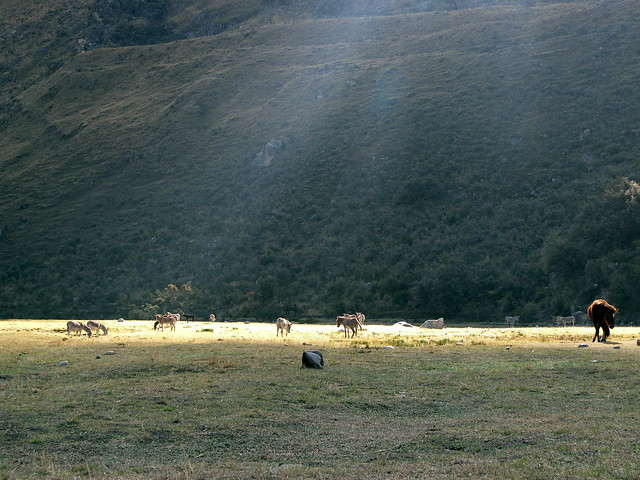

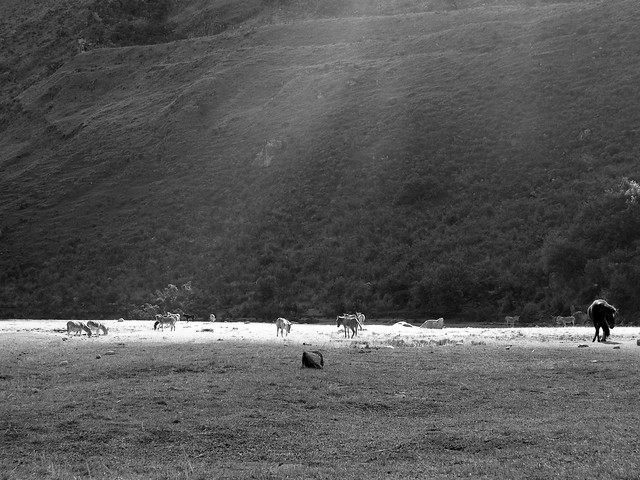

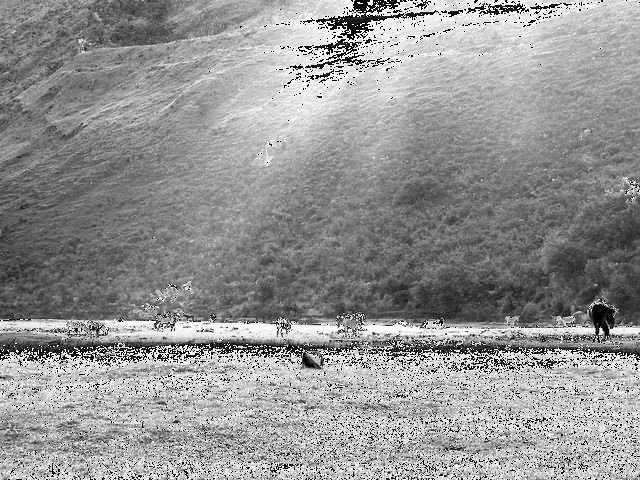

In [314]:
display(to_img(image_t), to_img(togray(image_t)) , to_img(togray_norm(togray(image_t))))


In [315]:
input256 = togray(to256(image_t))
input256_withnorm = togray_norm(togray(to256(image_t)))
input32 = togray(to32(image_t))
input32_withnorm = togray_norm(togray(to32(image_t)))
input512 = togray(to512(image_t))
input512_withnorm = togray_norm(togray(to512(image_t)))


### Inference on Rescaled image directly

In [316]:
with torch.no_grad():
    out512 = model_infer(input512.unsqueeze(0))
    out512_withnorm = model_infer(input512_withnorm.unsqueeze(0))
    out256 = model_infer(input256.unsqueeze(0))
    out256_withnorm = model_infer(input256_withnorm.unsqueeze(0))
    out32 = model_infer(input32.unsqueeze(0))
    out32_withnorm = model_infer(input32_withnorm.unsqueeze(0))

    
    

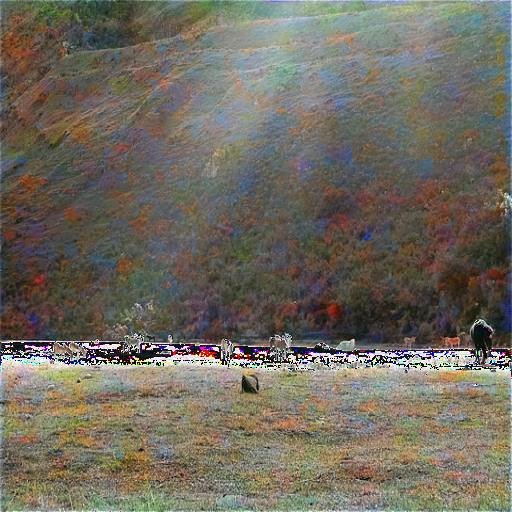

In [317]:
to_img(out512.squeeze(0)/2 + 0.5)

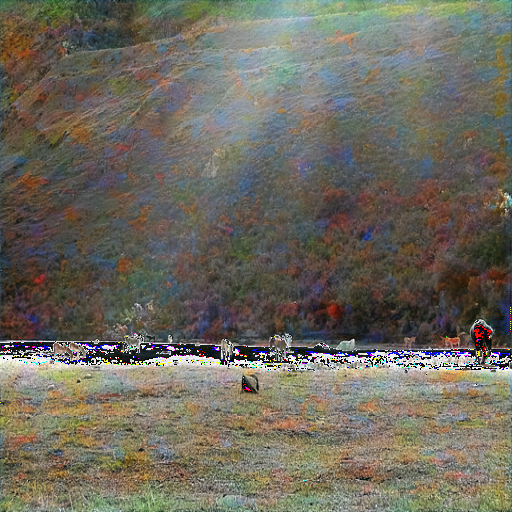

In [318]:
to_img(out512_withnorm.squeeze(0)*0.5 +0.5)

### patchwise colorization approach

In [319]:
#split image tensor into (32x32) patches and apply model on each patch
@torch.inference_mode()
def inferbypatch_image(image, patch_size = 32):
    h,w = image.shape[-2], image.shape[-1]
    image_out = torch.zeros((3,h,w))
    for i in range(0,h,patch_size):
        for j in range(0,w,patch_size):
            patch_in = image[...,i:i+patch_size,j:j+patch_size]
            patch_out = model_infer(patch_in.unsqueeze(0))
            image_out[...,i:i+patch_size,j:j+patch_size] = patch_out.squeeze(0)
    return image_out


In [323]:
def showbypatch_image(image, patch_size = 32):
    h,w = image.shape[-2], image.shape[-1]
    image_out = torch.zeros((3,h,w))
    for i in range(0,h,patch_size):
        for j in range(0,w,patch_size):
            patch_in = image[...,i:i+patch_size,j:j+patch_size]
            #patch_out = model_infer(patch_in.unsqueeze(0))
            image_out[...,i:i+patch_size,j:j+patch_size] = patch_in.squeeze(0)
    return image_out

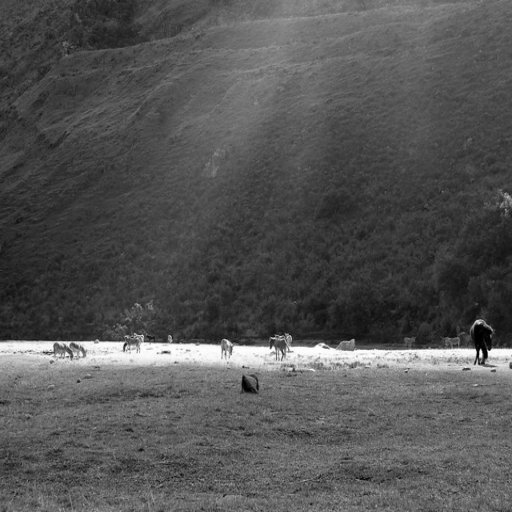

In [321]:
to_img(showbypatch_image(input512))

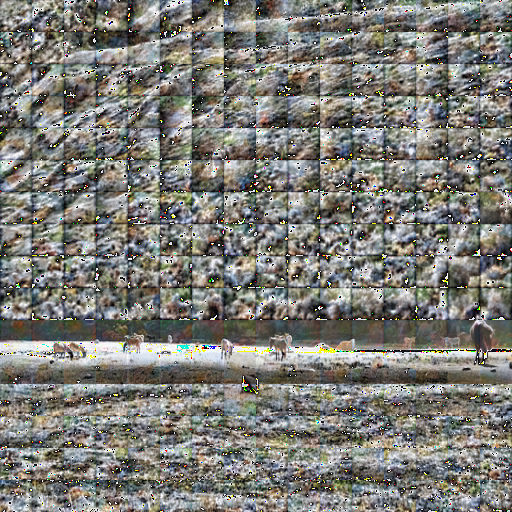

In [322]:
to_img(inferbypatch_image(input512_withnorm)/2 + 0.5)

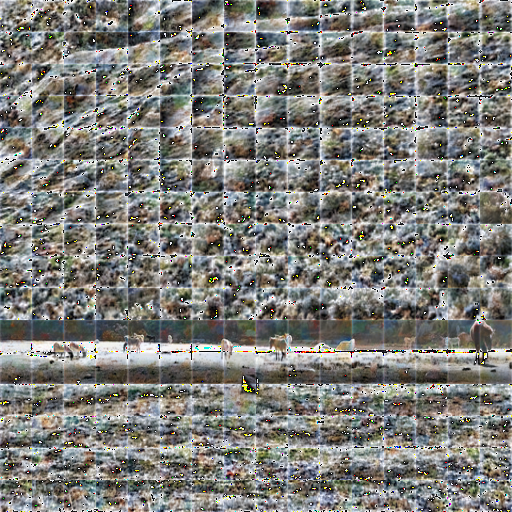

In [324]:
to_img(inferbypatch_image(input512)/2 + 0.5)